# **Diagnóstico Automatizado de Linfomas Malignos en Biopsias H&E mediante Aprendizaje Automático**
## *Aftab Ahmed Choudhry*

In [1]:
from PIL import Image
import os
import glob
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

## ***Conversión Única de Imágenes .tif a .png***

Esta celda se ejecuta **una sola vez** para convertir las imágenes originales descargadas desde Kaggle (en formato `.tif`) al formato `.png`, ya que `image_dataset_from_directory()` de TensorFlow **no soporta `.tif`**. Tras la conversión, las imágenes `.tif` se eliminan automáticamente.

In [2]:
base_path = './dataset'

for class_name in ['CLL', 'FL', 'MCL']:
    folder = os.path.join(base_path, class_name)
    tif_files = glob.glob(os.path.join(folder, '*.tif'))
    png_files = glob.glob(os.path.join(folder, '*.png'))

    if len(png_files) > 0:
        print(f"Conversión ya realizada para la clase {class_name}. Se omite.")
        continue

    for tif_path in tif_files:
        with Image.open(tif_path) as img:
            rgb_img = img.convert('RGB')
            new_path = tif_path.replace('.tif', '.png')
            rgb_img.save(new_path)

        os.remove(tif_path)
    
    print(f"Conversión completada para la clase {class_name}.")

Conversión ya realizada para la clase CLL. Se omite.
Conversión ya realizada para la clase FL. Se omite.
Conversión ya realizada para la clase MCL. Se omite.


## *Verificación de disponibilidad de GPU*

Esta celda comprueba si TensorFlow detecta una GPU en el entorno actual. Es útil para confirmar que la aceleración por hardware está activa y que se aprovechará la GPU durante el entrenamiento del modelo.

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


## Preproceso

In [4]:
def plot_accuracy_loss(history):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Carga de los datos

In [5]:
dataset_path = './dataset'
image_size = (1388, 1040)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size = image_size,
    shuffle = True,
    seed = 23,
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 374 files belonging to 3 classes.
Classes: ['CLL', 'FL', 'MCL']


### Visualización básica

In [ ]:
'''
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

    plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()} ({class_names[labels[i].numpy()]})")
        plt.axis("off")

### Partición del conjunto de datos

In [6]:
X = []
y = []

for images, labels in dataset:
    X.append(images.numpy())
    y.append(labels.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 1388, 1040, 3), (75, 1388, 1040, 3), (299,), (75,))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=23, stratify=y_train)

print("Train:", X_train.shape, y_train.shape)
print("Validation:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (269, 1388, 1040, 3) (269,)
Validation:   (30, 1388, 1040, 3) (30,)
Test:  (75, 1388, 1040, 3) (75,)


In [ ]:
'''
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
df_train = pd.DataFrame(X_train_flattened)
df_train['target'] = y_train
df_train.head()

Reordenaremos las columnas de manera que la variable target sea la primera

In [ ]:
'''
cols = list(df_train.columns)
cols.remove('target')
cols.insert(0,'target')
df_train = df_train.reindex(columns=cols)
df_train.head()

In [ ]:
#df_train.iloc[:, :1000].describe().T

In [ ]:
#df_train['target'].value_counts()

In [8]:
def resize_images(X):
    resized = []
    
    for img in X:
        img_resized = tf.image.resize(img, (299, 299))
        resized.append(img_resized.numpy())
        
    return np.array(resized)

In [9]:
X_train = resize_images(X_train)
X_val = resize_images(X_val)
X_test = resize_images(X_test)

X_train.shape, X_val.shape, X_test.shape

((269, 299, 299, 3), (30, 299, 299, 3), (75, 299, 299, 3))

In [10]:
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

## Entrenar la CNN

### InceptionV3

In [11]:
inceptionV3_base_model = InceptionV3(include_top = False)
inceptionV3_base_model.trainable = False

#### Freeze and Feature Extraction

In [12]:
inceptionV3_inputs = Input(shape=(299, 299, 3))

inceptionV3_x = inceptionV3_base_model(inceptionV3_inputs)

inceptionV3_x = GlobalAveragePooling2D()(inceptionV3_x)
inceptionV3_outputs = Dense(3, activation = 'softmax')(inceptionV3_x)

inceptionV3_model = Model(inceptionV3_inputs, inceptionV3_outputs)

inceptionV3_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


In [13]:
len(inceptionV3_base_model.layers)

311

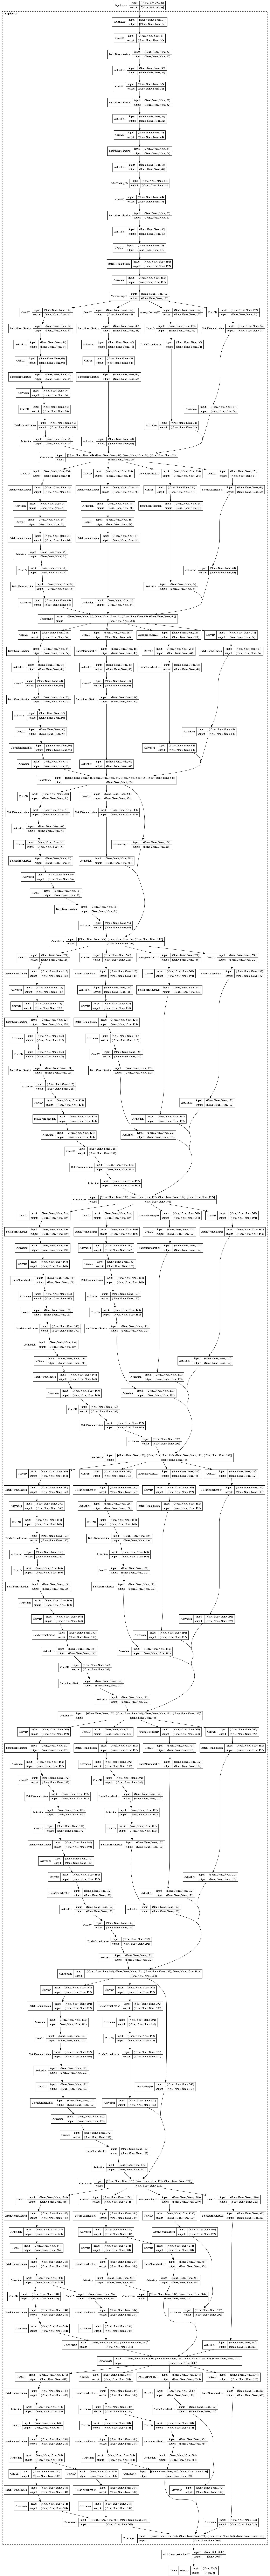

In [14]:
tf.keras.utils.plot_model(
    inceptionV3_model,
    to_file = 'InceptionV3.png',
    show_shapes = True,
    show_dtype = False,
    show_layer_names = False,
    show_layer_activations = True,
    expand_nested = True
)

In [15]:
inceptionV3_model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [16]:
EPOCHS = 30

In [17]:
inceptionV3_history = inceptionV3_model.fit(X_train, y_train, epochs = EPOCHS, validation_data = (X_val, y_val))

Epoch 1/30
9/9 [==============================] - 11s 379ms/step - loss: 1.0811 - accuracy: 0.4238 - val_loss: 1.0895 - val_accuracy: 0.3667
Epoch 2/30
9/9 [==============================] - 2s 181ms/step - loss: 0.9352 - accuracy: 0.5762 - val_loss: 1.1230 - val_accuracy: 0.4000
Epoch 3/30
9/9 [==============================] - 2s 180ms/step - loss: 0.8735 - accuracy: 0.6097 - val_loss: 1.0598 - val_accuracy: 0.5667
Epoch 4/30
9/9 [==============================] - 2s 180ms/step - loss: 0.8158 - accuracy: 0.6431 - val_loss: 1.0890 - val_accuracy: 0.4333
Epoch 5/30
9/9 [==============================] - 2s 181ms/step - loss: 0.8079 - accuracy: 0.6468 - val_loss: 0.9894 - val_accuracy: 0.6000
Epoch 6/30
9/9 [==============================] - 2s 181ms/step - loss: 0.7450 - accuracy: 0.6729 - val_loss: 0.9650 - val_accuracy: 0.5333
Epoch 7/30
9/9 [==============================] - 2s 182ms/step - loss: 0.6917 - accuracy: 0.7323 - val_loss: 0.9274 - val_accuracy: 0.6333
Epoch 8/30
9/9 [===

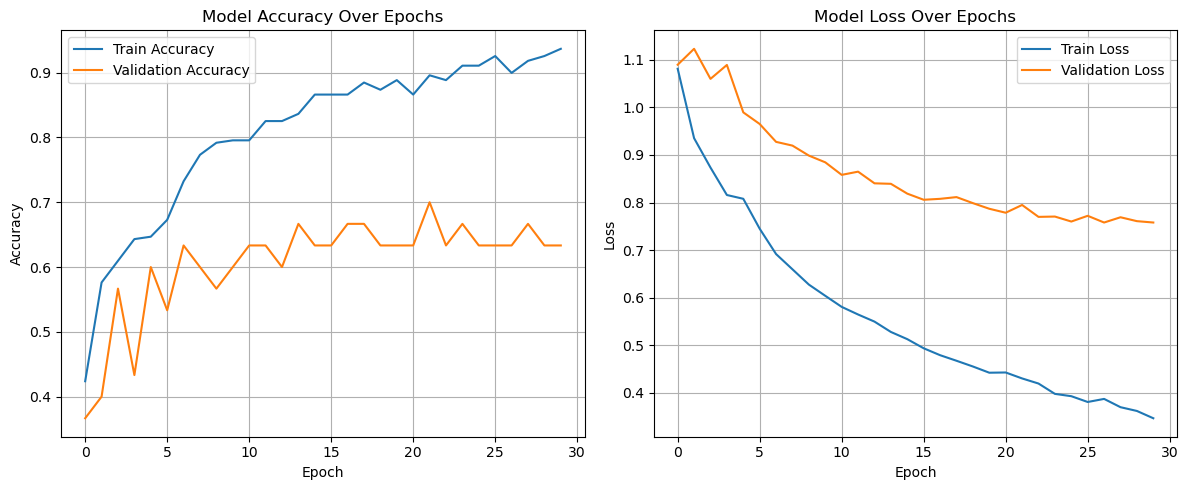

In [18]:
plot_accuracy_loss(inceptionV3_history)

#### Unfreeze and Fine-Tuning

In [19]:
inceptionV3_base_model.trainable = True
for layer in inceptionV3_base_model.layers[:-100]:
    layer.trainable = False

In [20]:
inceptionV3_x = inceptionV3_base_model(inceptionV3_inputs)

inceptionV3_x = GlobalAveragePooling2D()(inceptionV3_x)
inceptionV3_outputs = Dense(3, activation = 'softmax')(inceptionV3_x)

inceptionV3_model = Model(inceptionV3_inputs, inceptionV3_outputs)

inceptionV3_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 13,630,211
Non-trainable params: 8,178,720
_________________________________________________________________


In [21]:
inceptionV3_model.compile(loss = 'sparse_categorical_crossentropy',
                          optimizer = Adam(learning_rate = 1e-5),
                          metrics = ['accuracy'])

In [22]:
callbacks = [ModelCheckpoint('best_model.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1),
             ReduceLROnPlateau(monitor = 'val_accuracy', patience = 4, factor = 0.1, verbose = 1, min_lr = 1e-6),
             EarlyStopping(monitor = 'val_accuracy', patience = 5, verbose = 1)]

In [23]:
inceptionV3_history = inceptionV3_model.fit(X_train, y_train, epochs = EPOCHS + 30, initial_epoch = EPOCHS, validation_data = (X_val, y_val))

Epoch 31/60
9/9 [==============================] - 8s 405ms/step - loss: 1.1043 - accuracy: 0.3643 - val_loss: 1.1913 - val_accuracy: 0.3333
Epoch 32/60
9/9 [==============================] - 2s 233ms/step - loss: 0.9215 - accuracy: 0.6394 - val_loss: 1.1402 - val_accuracy: 0.3333
Epoch 33/60
9/9 [==============================] - 2s 232ms/step - loss: 0.8014 - accuracy: 0.7584 - val_loss: 1.1103 - val_accuracy: 0.3333
Epoch 34/60
9/9 [==============================] - 2s 234ms/step - loss: 0.6764 - accuracy: 0.8625 - val_loss: 1.0908 - val_accuracy: 0.4000
Epoch 35/60
9/9 [==============================] - 2s 233ms/step - loss: 0.5875 - accuracy: 0.9071 - val_loss: 1.0723 - val_accuracy: 0.5000
Epoch 36/60
9/9 [==============================] - 2s 234ms/step - loss: 0.5178 - accuracy: 0.9182 - val_loss: 1.0643 - val_accuracy: 0.4667
Epoch 37/60
9/9 [==============================] - 2s 233ms/step - loss: 0.4426 - accuracy: 0.9665 - val_loss: 1.0613 - val_accuracy: 0.4333
Epoch 38/60
9

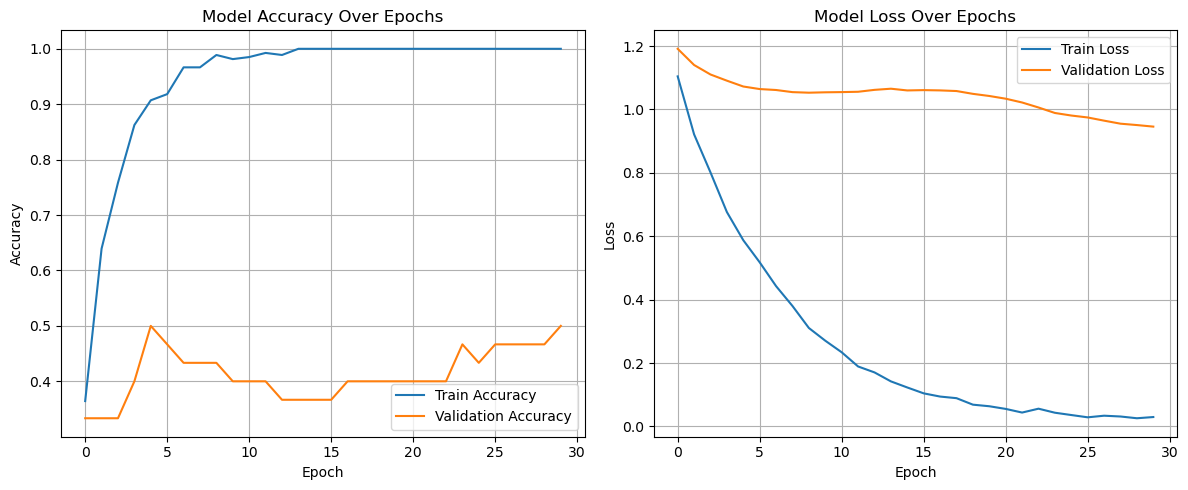

In [24]:
plot_accuracy_loss(inceptionV3_history)